In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [3]:
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf

2023-01-29 05:52:27.988884: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-29 05:52:27.989004: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Set up TPU.

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU

print('Number of replicas:', strategy.num_replicas_in_sync)

2023-01-29 05:52:33.093951: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-29 05:52:33.096530: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-29 05:52:33.096571: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-29 05:52:33.096599: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a76e66d33369): /proc/driver/nvidia/version does not exist
2023-01-29 05:52:33.099164: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8


## Downloading Data

In [5]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [6]:
from datasets import load_dataset

def load_mnli(use_validation=True):
    result=[]
    dataset=load_dataset('multi_nli')
    print(dataset)
    for record in dataset['train']:
        c1, c2, c3 = record['premise'],record['hypothesis'], record['label']
        if c1 and c2 and c3 in {0, 1, 2}:
            result.append((c1, c2, c3, 'en'))
    result=pd.DataFrame(result, columns=['premise', 'hypothesis', 'label', 'lang_abv'])
    return result

In [7]:
mnli = load_mnli()
mnli

Downloading:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/227M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})


,premise,hypothesis,label,lang_abv
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,en
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,en
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,en
3,How do you know? All this is their information...,This information belongs to them.,0,en
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,en
...,...,...,...,...
392697,"Clearly, California can - and must - do better.",California cannot do any better.,2,en
392698,It was once regarded as the most beautiful str...,So many of the original buildings had been rep...,1,en
392699,Houseboats are a beautifully preserved traditi...,The tradition of houseboats originated while t...,0,en
392700,Obituaries fondly recalled his on-air debates ...,The obituaries were beautiful and written in k...,1,en


In [8]:
from sklearn.model_selection import train_test_split

train = pd.concat([train, mnli.loc[:100000]], axis=0)
train

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
99996,NaN,When reporters asked whether Clinton should re...,Personal destruction politics should not decid...,en,NaN,0
99997,NaN,"For the hikers, a bus goes to a point quite cl...","At the summit, the view is said to be the best...",en,NaN,1
99998,NaN,The capital of the Gododdin was Din Eidyn (the...,"Edinburgh derived its name from Din Eidyn, the...",en,NaN,0
99999,NaN,"In any event, Gore dropped out of the race sho...","In each one of the events, Bush quit the race ...",en,NaN,2


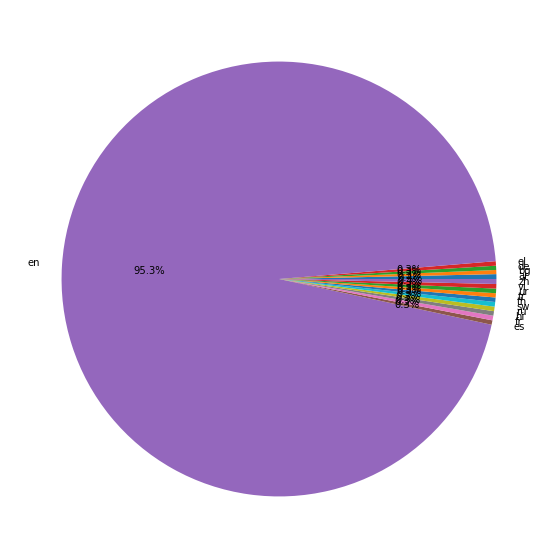

In [9]:
labels, frequencies = np.unique(train.lang_abv.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

## Preparing Data for Input

In [10]:
# Configuration

MAX_LEN = 128
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [11]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [12]:
def bert_encode(hypotheses, premises, tokenizer):

    num_examples = len(hypotheses)

    sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1).to_tensor(shape=[num_examples,MAX_LEN])

    input_mask = tf.ones_like(input_word_ids)

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor(shape=[num_examples,MAX_LEN])

    inputs = {
      'input_word_ids': input_word_ids,
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

    return inputs

In [13]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

## Creating & Training Model

In [14]:
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(embedding)
    vector = tf.keras.layers.Concatenate()([avg_pool, max_pool])
    dropouts = []
    for i in range(3):
        dropout = tf.keras.layers.Dropout(0.2 * (i + 1))(vector)
        dropout_output = tf.keras.layers.Dense(128, activation="swish")(dropout)
        dropouts.append(dropout_output)
    vector = tf.keras.layers.Average()(dropouts)
    output = tf.keras.layers.Dense(3, activation='softmax')(vector)
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
with strategy.scope():
    model = build_model()
    model.summary()

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

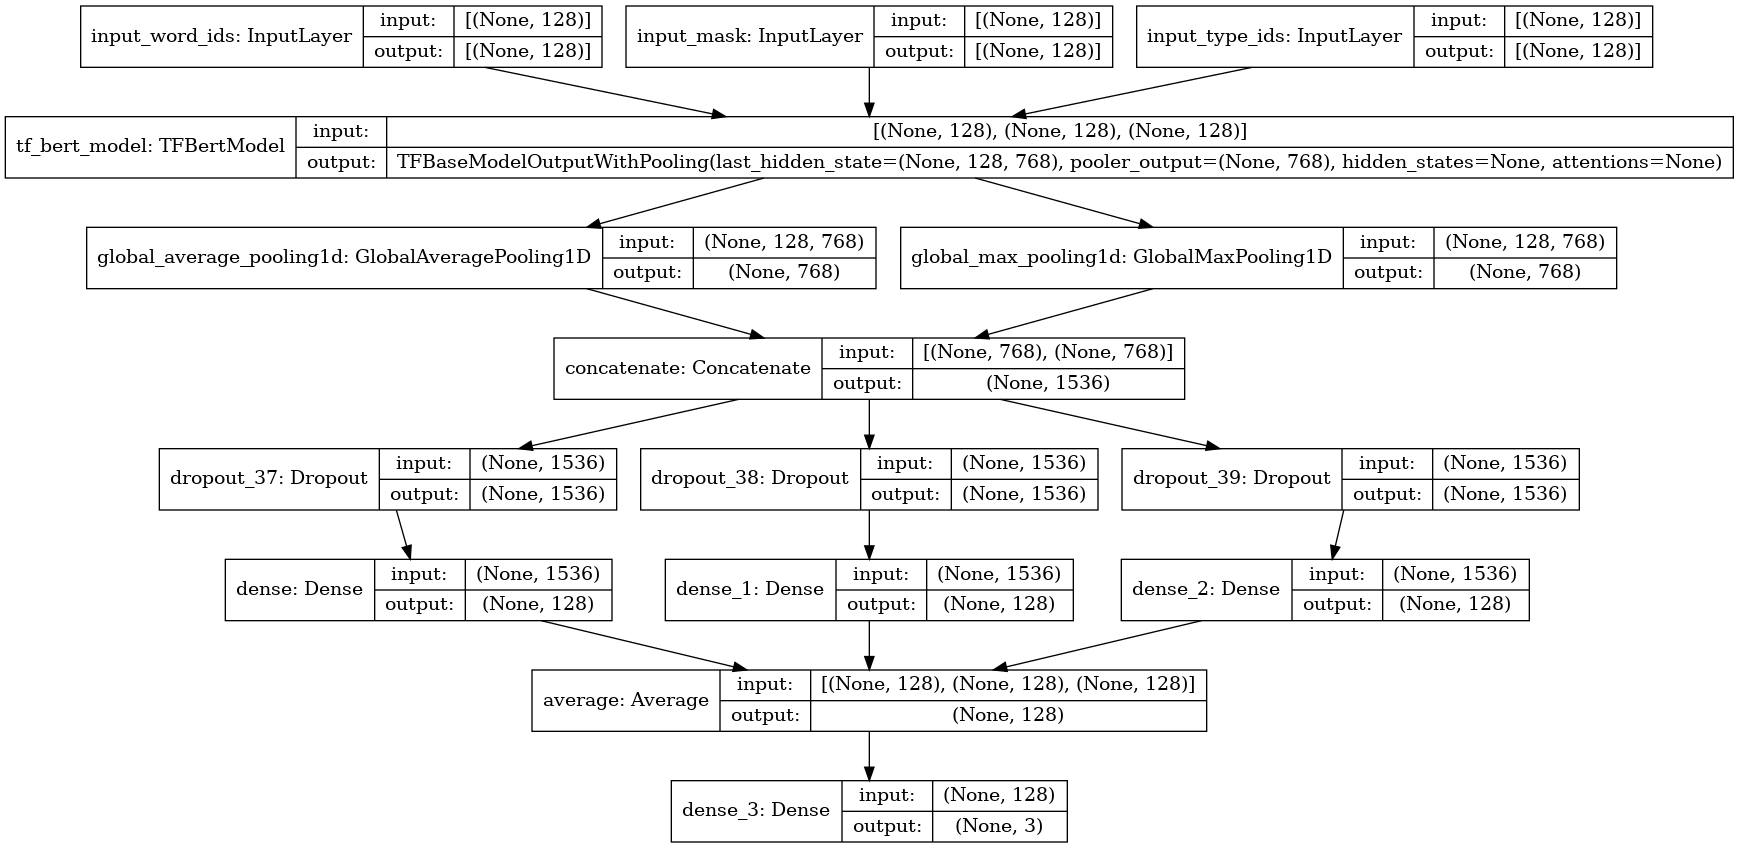

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

Epoch 1/10
868/868 [==============================] - 208s 158ms/step - loss: 0.9536 - accuracy: 0.5163 - val_loss: 0.6139 - val_accuracy: 0.7415
Epoch 2/10
868/868 [==============================] - 84s 97ms/step - loss: 0.6209 - accuracy: 0.7442 - val_loss: 0.5502 - val_accuracy: 0.7665
Epoch 3/10
868/868 [==============================] - 84s 97ms/step - loss: 0.5283 - accuracy: 0.7882 - val_loss: 0.5457 - val_accuracy: 0.7807
Epoch 4/10
868/868 [==============================] - 84s 96ms/step - loss: 0.4504 - accuracy: 0.8236 - val_loss: 0.5560 - val_accuracy: 0.7816
Epoch 5/10
868/868 [==============================] - 84s 97ms/step - loss: 0.3831 - accuracy: 0.8532 - val_loss: 0.5676 - val_accuracy: 0.7772
Epoch 6/10
868/868 [==============================] - 84s 96ms/step - loss: 0.3266 - accuracy: 0.8782 - val_loss: 0.6551 - val_accuracy: 0.7745
Epoch 7/10
868/868 [==============================] - 84s 97ms/step - loss: 0.2731 - accuracy: 0.8997 - val_loss: 0.6531 - val_accurac

<AxesSubplot:>

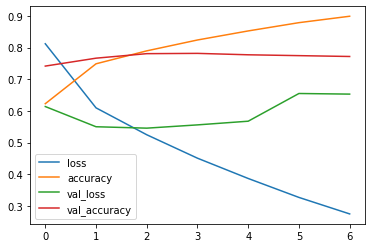

In [17]:
es = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")
checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True, save_weights_only=True, restore_best_weights=True)

history = model.fit(
    train_input, train.label.values, 
    validation_split = 0.01,
    epochs = 10, 
    verbose = 1, 
    batch_size = 128,
    callbacks=[es, checkpoint]
)

pd.DataFrame(history.history).plot()

In [18]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [19]:
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


## Generating & Submitting Predictions

In [20]:
predictions = [np.argmax(i) for i in model.predict(test_input)]

In [21]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

In [22]:
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1


In [23]:
submission.to_csv("submission.csv", index = False)